In [3]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import compose, pipeline, preprocessing, linear_model, model_selection, ensemble, feature_selection
import seaborn as sns
from tqdm import tqdm


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

idx = pd.IndexSlice

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

### Load all data

In [4]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [3]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

### Random Forest - possible feature combinations

In [5]:
### TRAINING
lags_default = [1, 2, 3, 4, 5, 6]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6],
    "gdp": [2, 3, 4, 5, 6],
    "unempl": [2, 3, 4, 5, 6],
}


model_names = [
    "bench-rw",
    "bench-rw-realistic",
    "19",
    "19+extra_kw",
    "gdp+unempl",
    "19+gdp+unempl",
    "19+gdp+unempl+extra_kw",
    "ar",
    "ar+19",
    "ar+19+extra_kw",
    "ar+gdp+unempl",
    "ar+19+gdp+unempl",
    "ar+19+gdp+unempl+extra_kw",
]

feature_combinations = [
    ["value"],
    ["value"],
    ["19"],
    ["19", "115", "28", "12"],
    ["gdp", "unempl"],
    ["19", "gdp", "unempl"],
    ["19", "115", "28", "12", "gdp", "unempl"],
    ["value"],
    ["value", "19"],
    ["value", "19", "115", "28", "12"],
    ["value", "gdp", "unempl"],
    ["value", "19", "gdp", "unempl"],
    ["value", "19", "115", "28", "12", "gdp", "unempl"],
]

lags = [
    [1],
    [2],
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
    lags_default,
]

alternate_lags = [
    {},
    {},
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
    alternate_lags_default,
]

use_linear_dummy = [True, True, False, False, False, False, False, False, False, False, False, False, False]

tuners, estimators = [], []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {
    "randomforestregressor__max_features": ["auto", "sqrt"],
    "randomforestregressor__min_samples_leaf": [1, 2, 4, 8],
    "randomforestregressor__min_samples_split": [2, 4, 8, 16, 32],
}

country_selection = ["ES", "IT", "PT", "GR"]


for i, name in enumerate(tqdm(model_names)):

    labeled = eumf_pipeline.prepare_data(
        panel_comb_3m_macro.loc[:, idx[:, country_selection]].sort_index(
            level=0, axis=1
        ),
        columns=feature_combinations[i],
        lags=lags[i],
        alternate_lags=alternate_lags[i],
        t_min=T_MIN,
        t_max=T_MAX,
    )
    transformed = eumf_pipeline.transform_data(labeled)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    if use_linear_dummy[i]:
        tuner = None
        estimator = eumf_custom_models.make_linear_dummy_model(
            train_stacked, features=[feature_combinations[i][0] + "_" + str(lags[i][0])]
        )
    else:
        tuner = eumf_pipeline.train_reg_model(
            train_stacked,
            reg=ensemble.RandomForestRegressor(random_state=42),
            extra_pipeline_steps=[preprocessing.StandardScaler()],
            params=params,
            scoring=eumf_eval.scorer_rmse,
            # dummy_encoder="drop",
        )
        estimator = tuner.best_estimator_
    tuners.append(tuner)
    estimators.append(estimator)

    cv_score = eumf_eval.score_cv(estimator, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(estimator, test_stacked,)
    test_scores.append(test_score)


100%|██████████| 13/13 [02:44<00:00, 12.69s/it]


In [6]:
pd.DataFrame(
    {
        k: t.best_params_
        for k, t in zip(model_names, tuners)
        if t is not None
    }
).transpose()



,randomforestregressor__max_features,randomforestregressor__min_samples_leaf,randomforestregressor__min_samples_split
19,sqrt,1,2
19+extra_kw,sqrt,1,2
gdp+unempl,sqrt,8,32
19+gdp+unempl,sqrt,4,16
19+gdp+unempl+extra_kw,sqrt,1,4
ar,auto,8,2
ar+19,auto,4,2
ar+19+extra_kw,sqrt,1,4
ar+gdp+unempl,auto,8,2
ar+19+gdp+unempl,auto,4,16


In [7]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                       score_time                       test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
                            mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
bench-rw                    0.003   6.215e-04  2.197e-04    0.005    1.324e-03  4.681e-04  -0.066   0.010  0.003   -0.085   0.014  0.005           0.215          0.488  0.173     0.469    0.506  0.179      0.099      0.130  0.046
bench-rw-realistic          0.003   7.900e-04  2.793e-04    0.004    9.345e-04  3.304e-04  -0.089   0.024  0.008   -0.114   0.036  0.013          -0.137          0.533  0.188     0.273    0.487  0.172      0.076      0.116  0.041
19                          0.108   8.199e-03  2.899e-03    0.013    1.007e-03  3.561e-04  -0.088   0.031  0.011   -0.111   0.039  0.014           0.114          0.289  0.102     0.305    0.622  0.220      0.077      0.109  0.039
19+extra_kw                 0.120   1.106e-02  3.909e-03    0.014    1.214e-03  4.292e-04  -0.082   0.034  0.012   -0.100   0.037  0.013           0.286          0.348  0.123     0.393    0.545  0.193      0.083      0.109  0.039
gdp+unempl                  0.097   1.170e-02  4.137e-03    0.013    1.777e-03  6.283e-04  -0.137   0.064  0.022   -0.158   0.075  0.027          -0.024          0.296  0.105    -0.030    0.481  0.170      0.028      0.080  0.028
19+gdp+unempl               0.105   9.382e-03  3.317e-03    0.014    2.131e-03  7.535e-04  -0.104   0.043  0.015   -0.122   0.052  0.018           0.161          0.280  0.099     0.291    0.437  0.154      0.061      0.101  0.036
19+gdp+unempl+extra_kw      0.112   9.219e-03  3.259e-03    0.013    9.831e-04  3.476e-04  -0.099   0.043  0.015   -0.117   0.051  0.018           0.243          0.203  0.072     0.354    0.383  0.135      0.066      0.101  0.036
ar                          0.112   2.009e-02  7.103e-03    0.013    1.179e-03  4.168e-04  -0.101   0.052  0.018   -0.127   0.060  0.021          -0.029          0.425  0.150     0.271    0.370  0.131      0.064      0.099  0.035
ar+19                       0.141   1.025e-02  3.623e-03    0.015    1.081e-03  3.822e-04  -0.087   0.037  0.013   -0.111   0.041  0.014           0.098          0.349  0.124     0.355    0.411  0.145      0.078      0.105  0.037
ar+19+extra_kw              0.143   2.684e-02  9.490e-03    0.016    2.707e-03  9.572e-04  -0.091   0.047  0.017   -0.107   0.047  0.017           0.297          0.276  0.097     0.391    0.411  0.145      0.074      0.104  0.037
ar+gdp+unempl               0.148   9.251e-03  3.271e-03    0.016    1.120e-03  3.959e-04  -0.113   0.058  0.020   -0.137   0.066  0.023          -0.020          0.452  0.160     0.165    0.475  0.168      0.051      0.094  0.033
ar+19+gdp+unempl            0.128   1.276e-02  4.513e-03    0.013    6.916e-04  2.445e-04  -0.096   0.044  0.016   -0.118   0.050  0.018           0.128          0.316  0.112     0.334    0.375  0.133      0.069      0.103  0.036
ar+19+gdp+unempl+extra_kw   0.194   1.285e-02  4.542e-03    0.014    1.514e-03  5.352e-04  -0.091   0.040  0.014   -0.112   0.042  0.015           0.175          0.334  0.118     0.379    0.366  0.129      0.074      0.101  0.036

In [8]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names).sort_values("rmse", ascending=False)

,mae,rmse,explained_variance,r2_mod,delta_mae
bench-rw,-0.075,-0.101,0.641,0.629,0.064
19+extra_kw,-0.075,-0.103,0.726,0.618,0.063
ar+19,-0.073,-0.104,0.711,0.607,0.065
19,-0.082,-0.115,0.571,0.517,0.057
ar,-0.088,-0.116,0.653,0.515,0.050
ar+19+extra_kw,-0.092,-0.122,0.750,0.460,0.047
ar+19+gdp+unempl+extra_kw,-0.103,-0.128,0.731,0.405,0.035
ar+gdp+unempl,-0.099,-0.129,0.648,0.391,0.039
ar+19+gdp+unempl,-0.102,-0.130,0.726,0.389,0.036
bench-rw-realistic,-0.114,-0.150,0.401,0.186,0.024


#### Performance by year (CV+test)

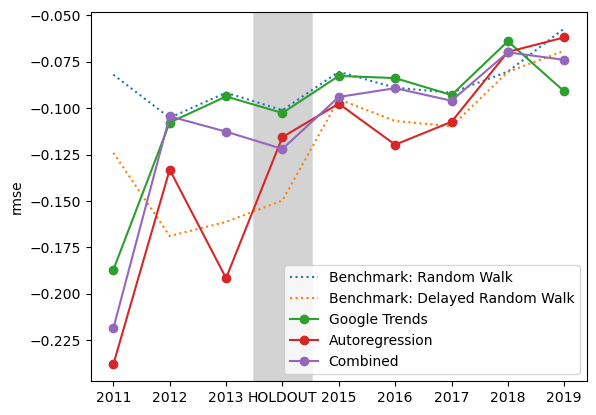

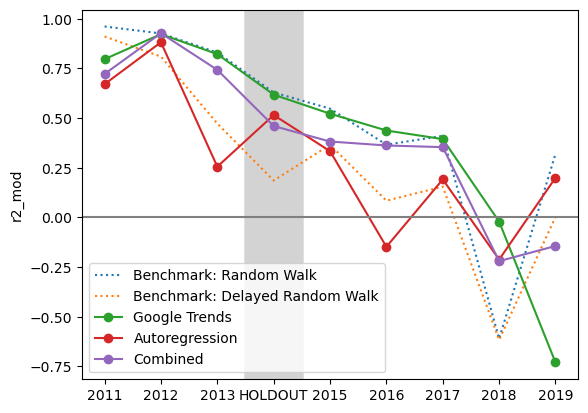

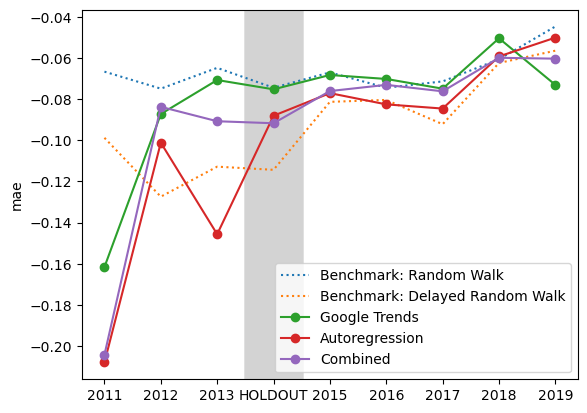

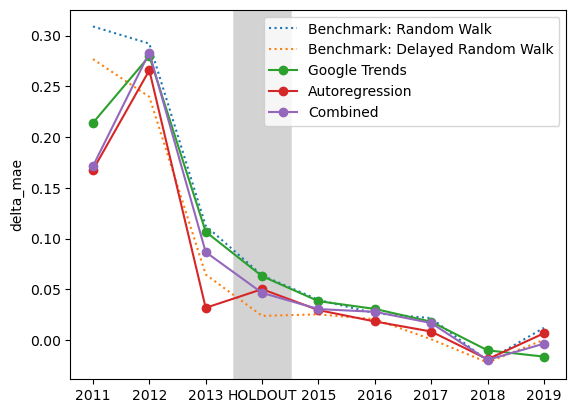

In [43]:
comp_models = ["bench-rw", "bench-rw-realistic", "19+extra_kw", "ar", "ar+19+extra_kw"]
model_labels = ["Benchmark: Random Walk", "Benchmark: Delayed Random Walk", "Google Trends", "Autoregression", "Combined"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["rmse", "r2_mod", "mae", "delta_mae"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        plot_labels=model_labels,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
    )
    if m == "r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()


#### Performance by country

In [57]:
test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[1], train_unstackeds[1], cv_default)

test scores

In [58]:
i = model_names.index("19+extra_kw")


In [59]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,0.069,0.086,0.346,0.840,0.136
ES,0.033,0.040,0.681,0.753,0.028
GR,0.060,0.069,-0.113,0.438,0.027
PT,0.151,0.175,0.108,0.378,0.050


CV scores

In [60]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("rmse", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance               r2_mod               delta_mae              
    mean   std    sem    mean   std    sem          mean         std    sem    mean   std    sem      mean    std    sem  
GR  0.101  0.077  0.027  0.117  0.075  0.027       -0.245        1.109  0.392 -0.268  1.167  0.413    0.072   0.150  0.053
ES  0.084  0.043  0.015  0.092  0.043  0.015        0.377        0.317  0.112  0.489  0.508  0.180    0.107   0.115  0.041
PT  0.071  0.030  0.011  0.084  0.029  0.010        0.244        0.322  0.114  0.095  1.720  0.608    0.080   0.115  0.041
IT  0.073  0.054  0.019  0.079  0.053  0.019       -0.194        0.646  0.228 -0.168  1.575  0.557    0.072   0.135  0.048

plot RMSE absolute

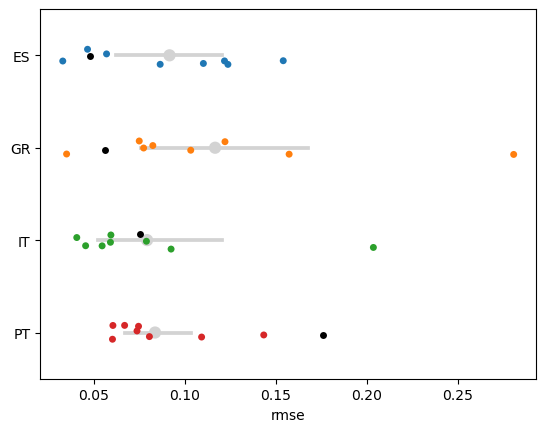

In [51]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="rmse",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="rmse")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="rmse", color="k")
plt.ylabel("")
plt.show()


plot MAE absolute

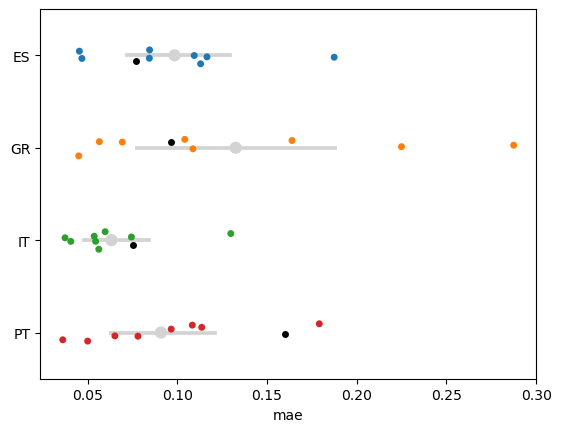

In [21]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


plot MAE delta

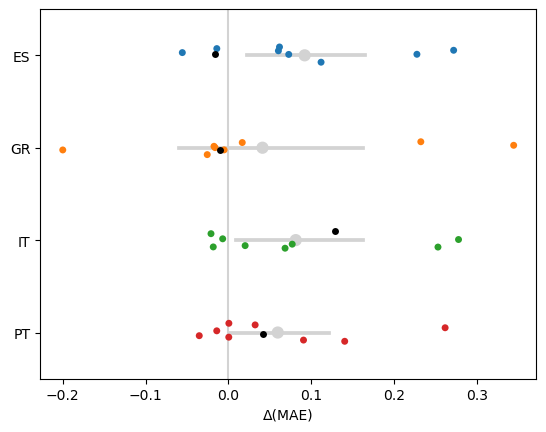

In [22]:
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="delta_mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="delta_mae")
sns.stripplot(data=test_scores_c.reset_index(), y="index", x="delta_mae", color="k")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### How important is Google Trends for each country? (diff KW19 vs no KW19)


##### without own lags

In [61]:
i1 = model_names.index("19+extra_kw")
i2 = model_names.index("ar")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0)

cv_diff_agg["rmse"]

,mean,std,sem
ES,0.028,0.063,0.022
GR,0.040,0.051,0.018
IT,-0.002,0.033,0.012
PT,0.037,0.078,0.028


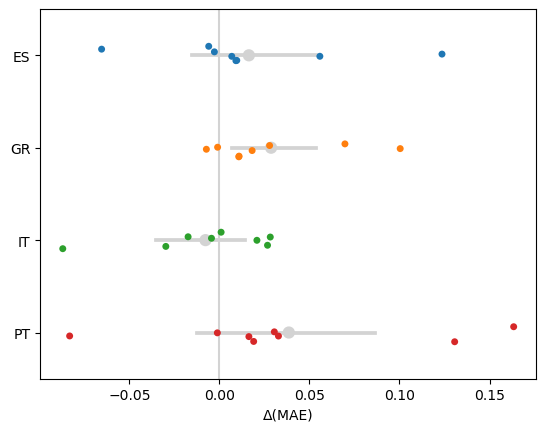

In [62]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
# sns.boxenplot(
#     data=cv_diff.reset_index(),
#     y="level_0",
#     x="mae",
#     # linestyles="",
#     # color="lightgrey",
#     # linewidth=0.0
# )
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


##### with own lags

In [25]:
i1 = model_names.index("ar+19+gdp+unempl")
i2 = model_names.index("ar+gdp+unempl")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0,)

cv_diff_agg["rmse"]

,mean,std,sem
ES,0.024,0.024,0.009
GR,0.013,0.028,0.010
IT,0.022,0.023,0.008
PT,0.016,0.028,0.010


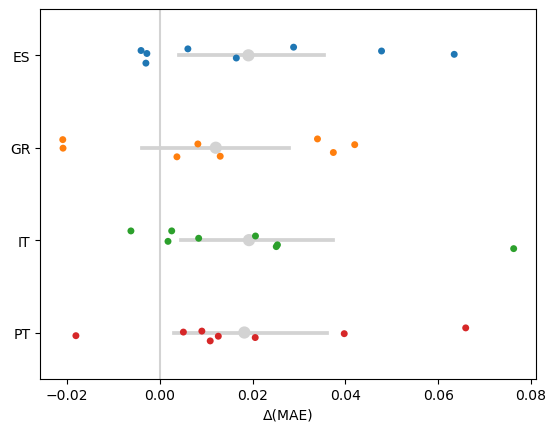

In [26]:
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="lightgrey",
)
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae")
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.show()


#### feature importance

In [27]:
i = model_names.index("19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=False
)

19_2          2.267e-01
19_3          1.871e-01
unempl_2      1.260e-01
unempl_3      9.083e-02
19_1          7.522e-02
19_4          5.604e-02
unempl_4      5.518e-02
unempl_5      5.120e-02
gdp_2         3.011e-02
unempl_6      2.283e-02
gdp_3         1.763e-02
gdp_4         1.707e-02
gdp_6         1.526e-02
19_5          1.064e-02
gdp_5         7.887e-03
country_GR    3.949e-03
19_6          3.939e-03
country_ES    1.543e-03
country_IT    8.214e-04
country_PT    3.204e-05
dtype: float64

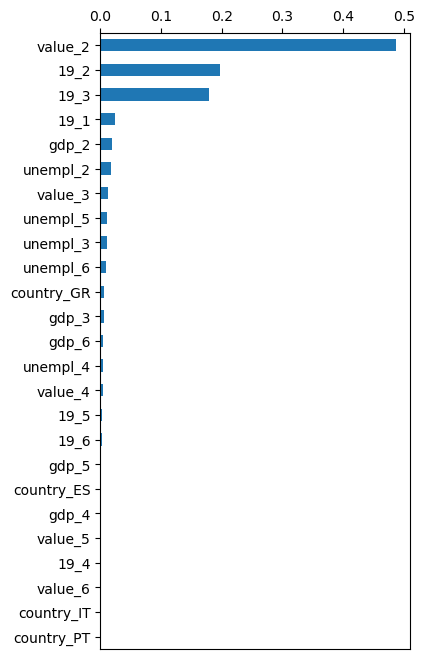

In [28]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_
features_names_out = reg.steps[0][1].get_feature_names_out()
plt.figure(figsize=(4,8))
pd.Series(reg.steps[-1][1].feature_importances_, index=features_names_out).sort_values(
    ascending=True
).plot(kind="barh")
plt.gca().xaxis.tick_top()
plt.show()

#### Plot prediction

all features

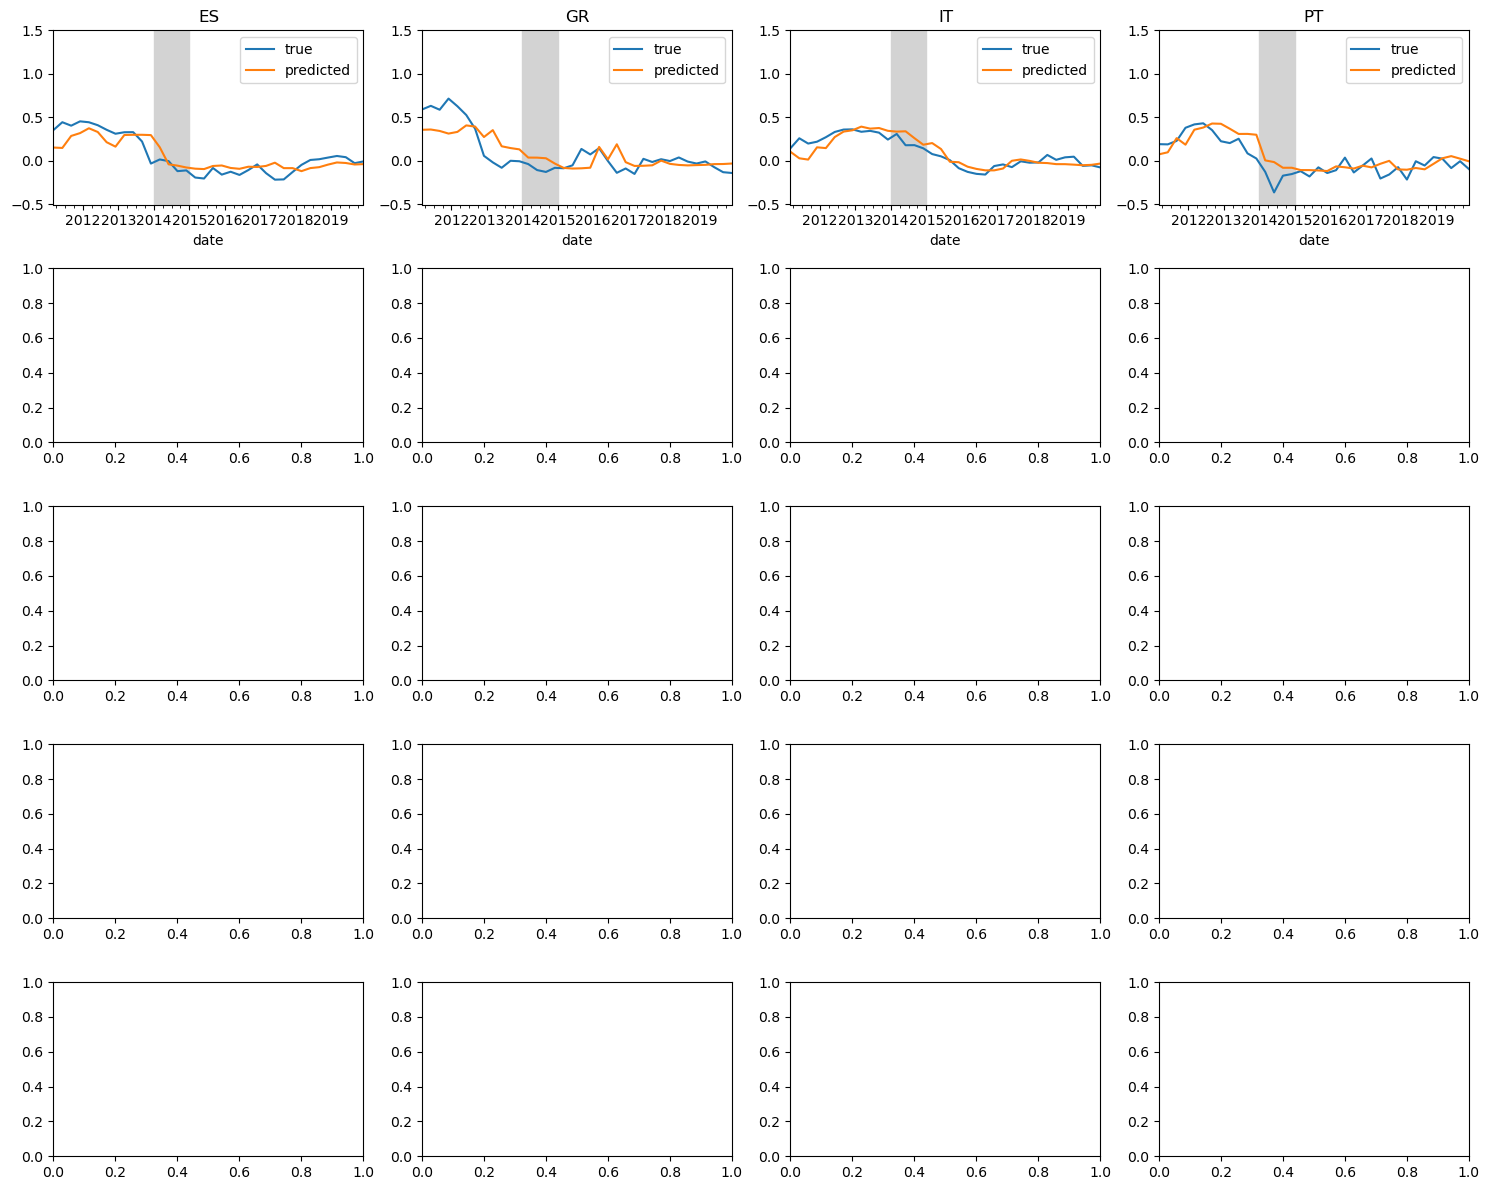

In [29]:
i = model_names.index("ar+19+gdp+unempl")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


Without own lags

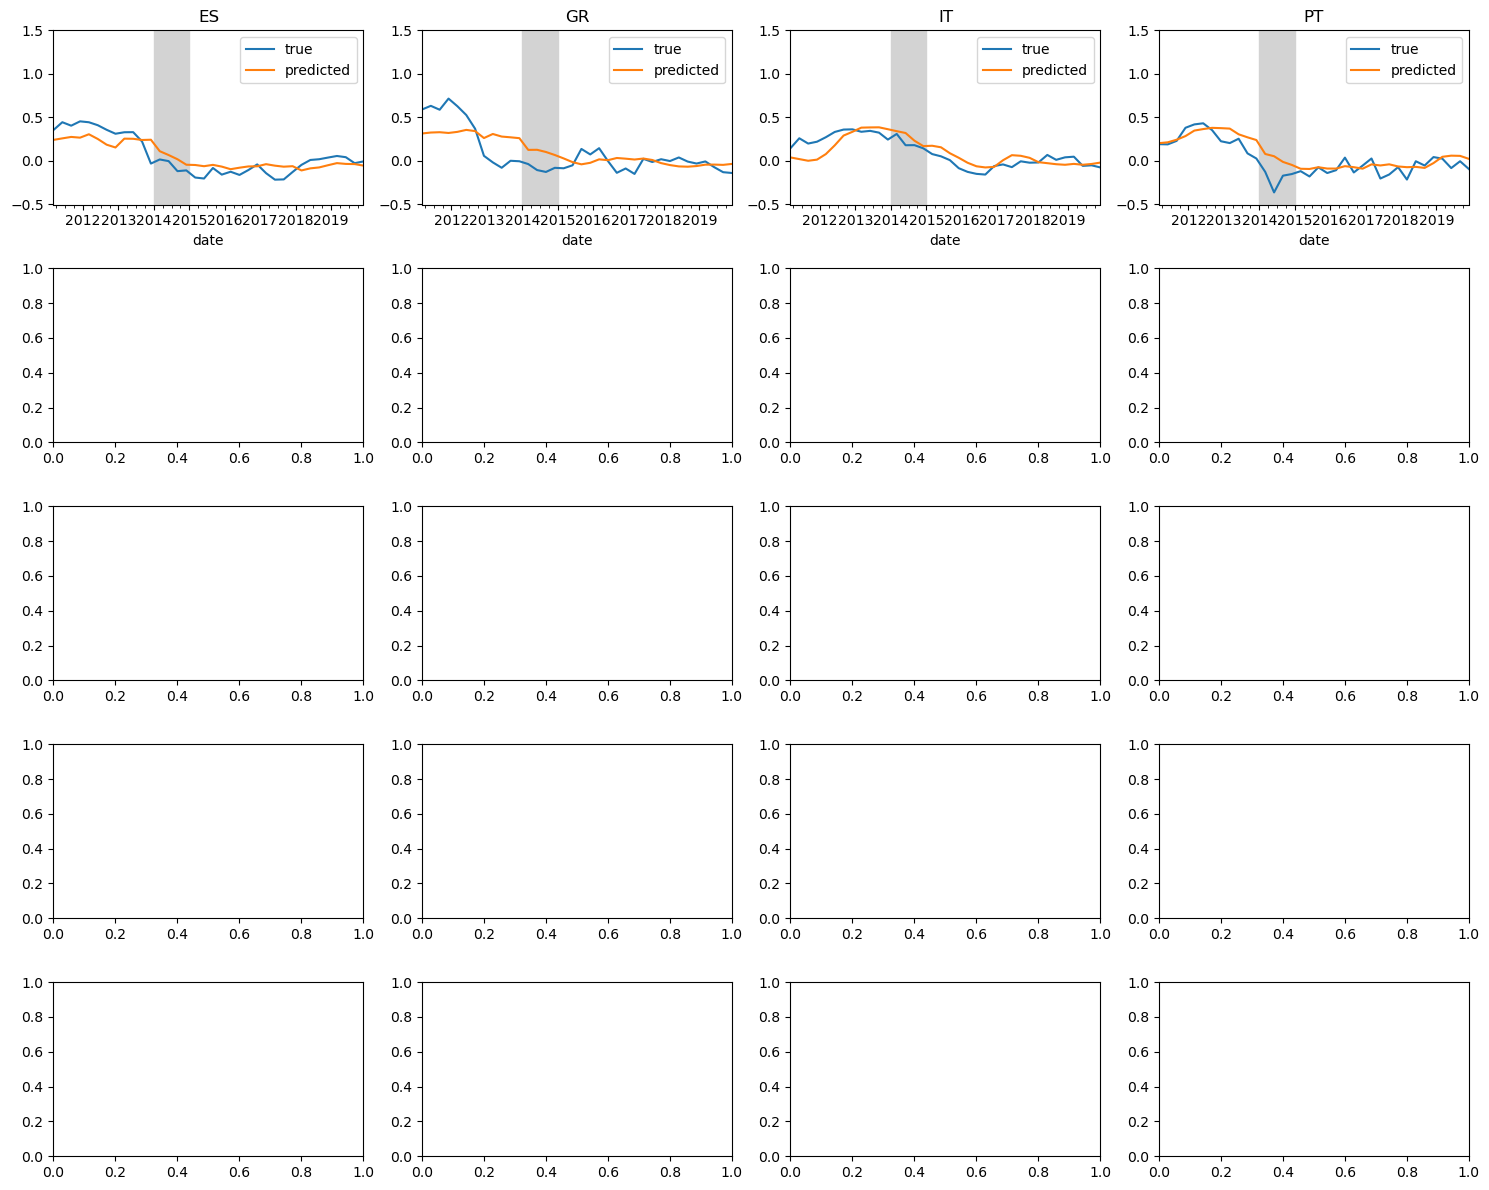

In [30]:
i = model_names.index("19+gdp+unempl")

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

Comparison

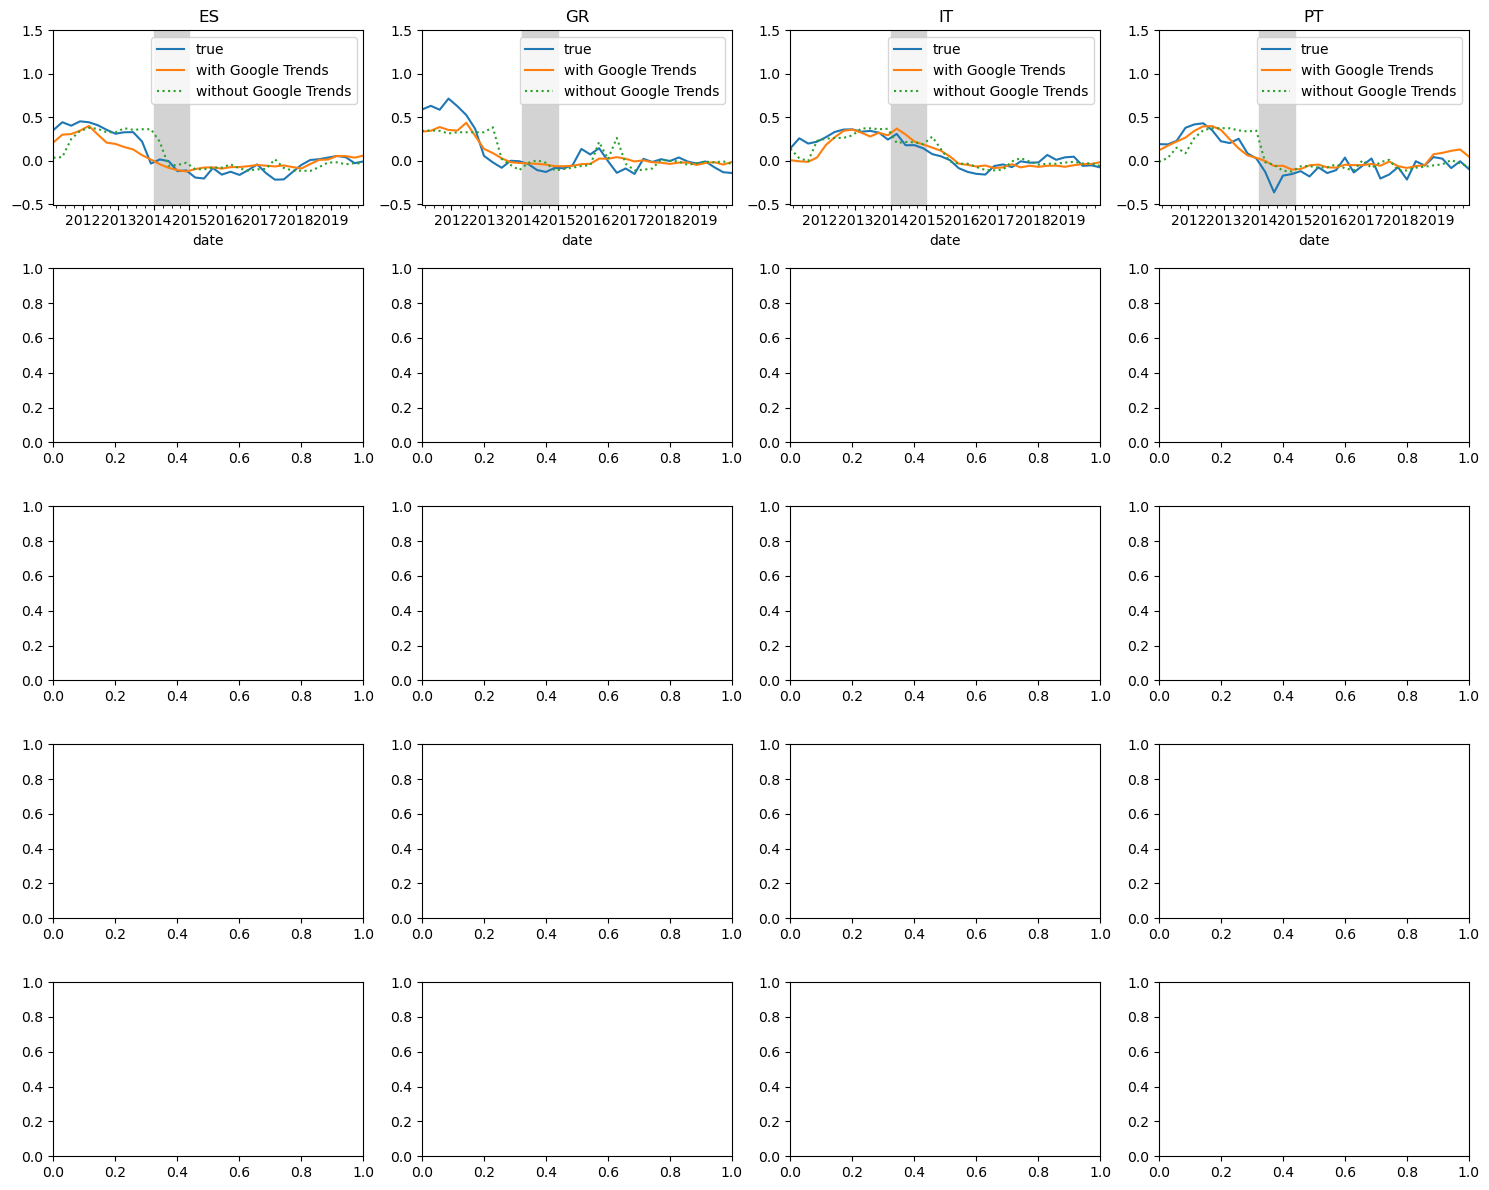

In [47]:
i1 = model_names.index("19+extra_kw")
i2 = model_names.index("ar")

y_pred_i1 = eumf_eval.predict_all(tuners[i1].best_estimator_, train_stackeds[i1], test_stackeds[i1], cv_default)
y_pred_i2 = eumf_eval.predict_all(tuners[i2].best_estimator_, train_stackeds[i2], test_stackeds[i2], cv_default)

y_preds_all= {"with Google Trends": y_pred_i1, "without Google Trends": y_pred_i2}

fig, axs = eumf_eval.plot_predictions(
    y_preds_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
    style={"without Google Trends": ":"}
)
plt.show()